# Challenge : predict conversions

## Import libraries

In [48]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV

# import models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE
from IPython.display import display


## Read file with labels

In [49]:
# download the csv file
data = pd.read_csv('conversion_data_train.csv')

# give the size of the dataset
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


Our dataset has a large quantity of events but not too many features.

In [50]:
# overview of the dataset
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


## PART 1 - EXPLORE DATASET

In [51]:
# Sample of the dataset before exploration in order to facilitate it
data_sample = data.sample(10000)

#### A- Description dataset

In [52]:
data_sample.describe(include="all")

,country,age,new_user,source,total_pages_visited,converted
count,10000,10000.000000,10000.000000,10000,10000.000000,10000.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,5662,NaN,NaN,4929,NaN,NaN
mean,NaN,30.711100,0.680100,NaN,4.863800,0.034000
std,NaN,8.299381,0.466461,NaN,3.355708,0.181238
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,6.250000,0.000000


No missing values but some outliers regarding the features "age" and "total_pages_visited"

#### B- Outliers

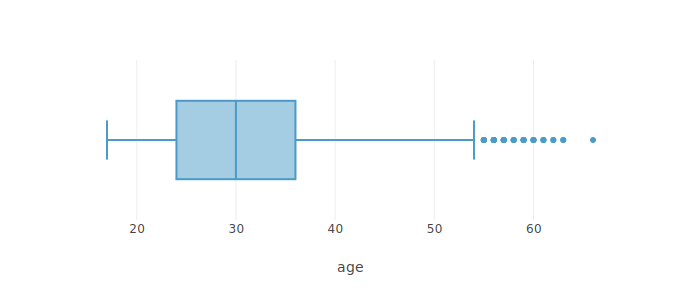

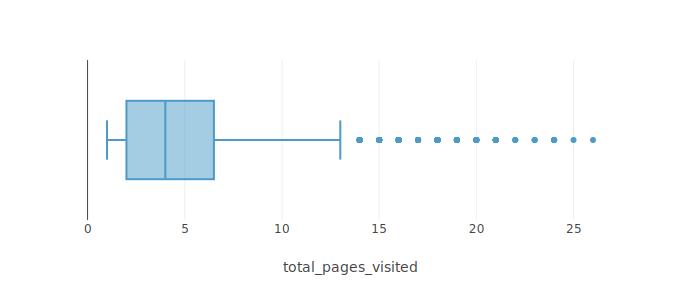

In [53]:
# checking the outliers more precisely for these two columns
for name in ["age","total_pages_visited"] :
    fig = px.box(data_sample,
                 x=name,
                 height=300)
    fig.show()

The significant size of the global dataset allows us to cancel rows with outliers

In [54]:
# create two masks in order to filter the original dataset
# we will remove values for columns age and total_pages_visited when they are > mean + 3 * standard deviation
mask1 = data["age"] <= (data["age"].mean() + 3 * data["age"].std())
mask2 = data["total_pages_visited"] <= (data["total_pages_visited"].mean() + 3 * data["total_pages_visited"].std())
data_clean = data.loc[mask1 & mask2, :]

In [55]:
print("{} rows have been removed from the original dataset.".format(data.shape[0]-data_clean.shape[0]))

6131 rows have been removed from the original dataset.


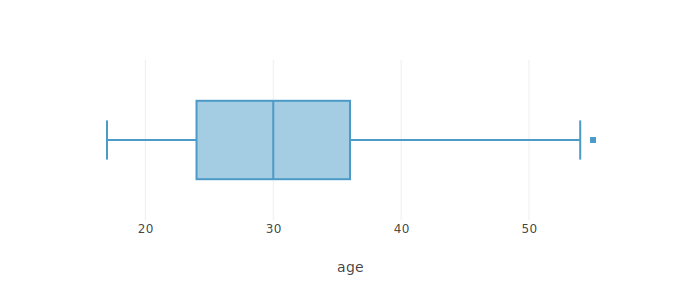

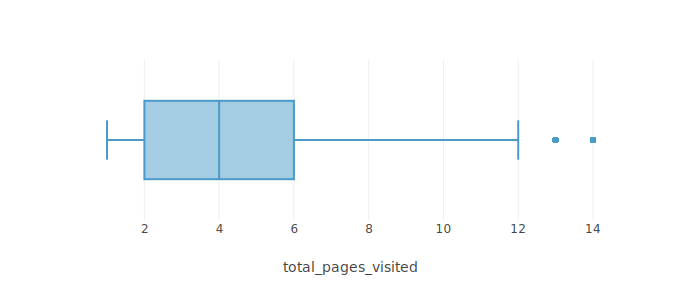

In [56]:
# checking the job done
for name in ["age","total_pages_visited"] :
    fig = px.box(data_clean,
                 x=name,
                 height=300)
    fig.show()

#### C- Types of data

In [57]:
# gives a summary of the DataFrame, including the data types of each column and the number of non-null values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


Confirmation that there is no missing values. Two variables are string and four variables are integers

#### D- Univariate analysis

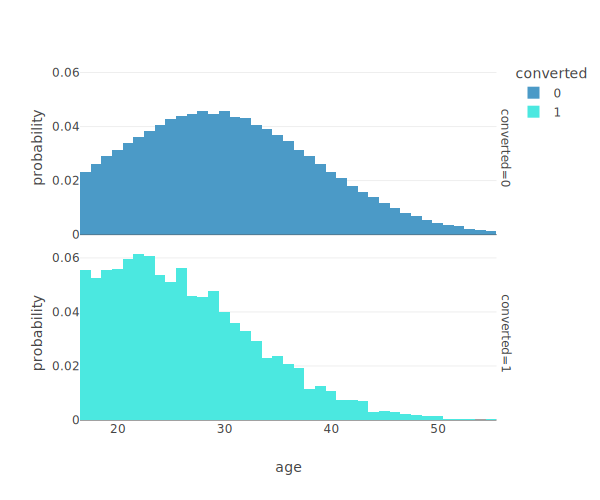

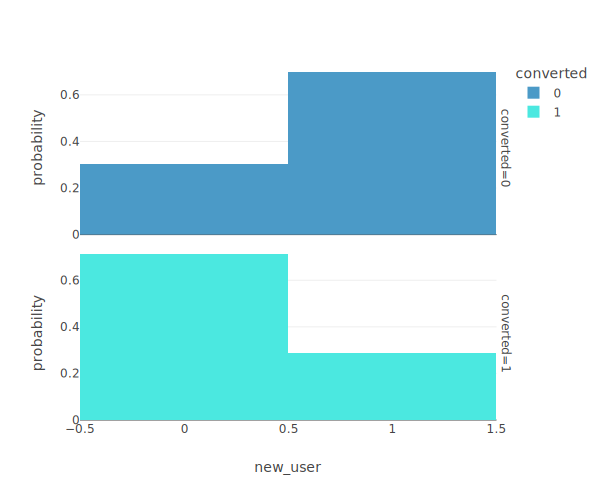

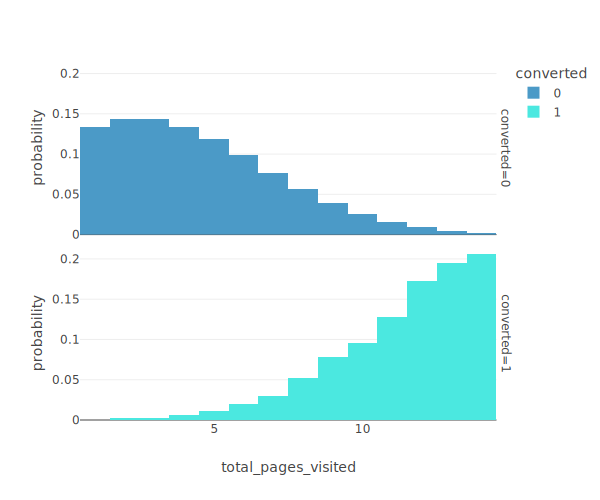

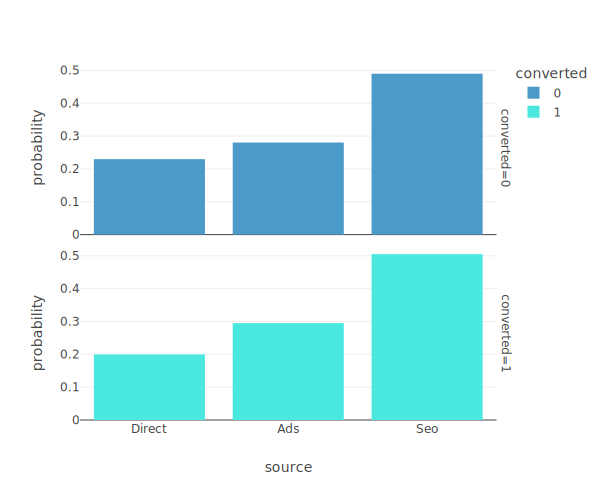

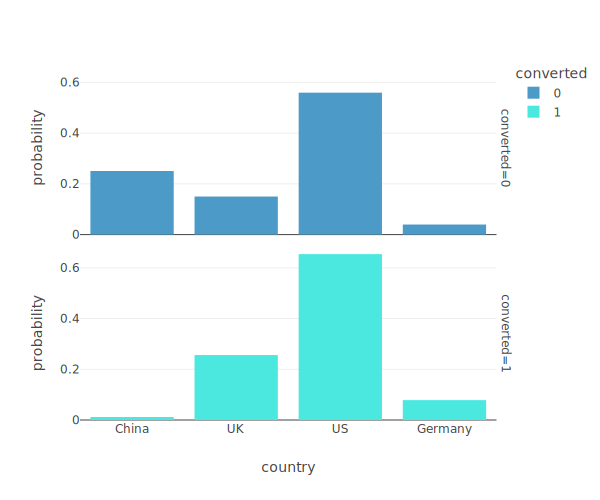

In [58]:
# for each features, visualization of distribution according to the target (converted)
# the comparison of the distribution can help us to detect a correlation
for variable in ["age", "new_user", "total_pages_visited","source","country"] :
    fig = px.histogram(data_clean,
                       x=variable, # display a changing variable
                       color = "converted",  # the histogram bars will be colored based on the values in the "converted" column
                       width=600,
                       facet_row="converted", # used to split histogram into two rows, one for each unique value in the "converted" column.
                       histnorm="probability") # specifies the normalization method for the histogram (in this case "probability", that is to say sum is 100%)
    fig.show()

we can conclude that :
- the number of pages visited is a good indicator of conversion or not, the greater the number of pages visited, the more likely conversion is
- the notion of customer is also quite discriminatory, converted people being rather new users
- age seems to be a less discriminating criterion even if we note that the converts are generally rather young
- the "country" variable is not very discriminating. there is no real difference between converted or not depending on origin except for the Chinese
- the notion of source does not provide any element in detection

#### E- Distribution of the target variable

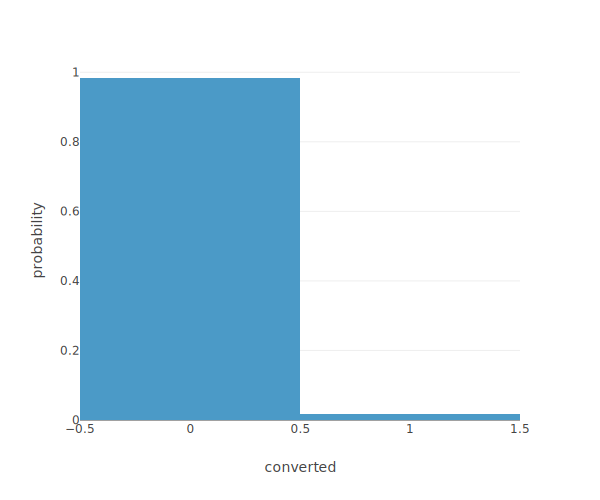

In [59]:
fig = px.histogram(data_clean,
                   x="converted", # column to display
                   width=600,
                   histnorm="probability") # specifies the normalization method for the histogram (in this case "probability", that is to say sum is 100%)
fig.show()

The distribution of the target variable is very unbalanced. \
So, the accuracy score won't be a good way to assess the performance of our model. Indeed, with this kind of score, a dummy model predicting always a no conversion will have a good score.

For the following models, we will use these metrics :

- Precision: Percentage of correct positive predictions relative to total positive predictions.
- Recall: Percentage of correct positive predictions relative to total actual positives.
- F1 score : A weighted harmonic mean of precision and recall (2 * (Precision * Recall) / (Precision + Recall))


## PART 2 - MULTIVARIATE LOGISTIC REGRESSION WITH GLOBAL DATASET

We first used the global dataset without removing outliers as we have seen just above

In [60]:
# data selection
target_variable = "converted"
X = data.iloc[:,:-1]
Y = data.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'source', 'total_pages_visited'], dtype='object')



In [61]:
# size of features set and tagret set
X.shape, Y.shape

((284580, 5), (284580,))

In [62]:
# Divide dataset Train set with 80% of data and Test set the remaining
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y) # stratify helps to ensure that the train and test sets have the same proportion of class labels as the input dataset
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [63]:
# size of features dataset for train and test set
X_train.shape, X_test.shape

((227664, 5), (56916, 5))

In [64]:
# overview of train set for features
X_train

,country,age,new_user,source,total_pages_visited
137434,China,19,1,Seo,1
112323,US,33,1,Direct,5
143261,US,51,1,Ads,2
162328,China,17,0,Seo,1
158039,China,28,1,Seo,5
...,...,...,...,...,...
132514,US,29,0,Seo,15
243326,China,45,0,Seo,3
136997,US,31,0,Ads,1
70286,UK,27,0,Ads,9


#### A- Training pipeline

In [65]:
# set preprocessing for categorical features
# notice that we considered new_user as a categorical feature even if the type of data is numerical (integer)
cat_features = ["country", "new_user","source"]
cat_transformer = OneHotEncoder(drop="first") # indicates that the first level of each categorical variable will be dropped to avoid multicollinearity.

# set preprocessing for numerical features
num_features = ["age","total_pages_visited"]
num_transformer = StandardScaler() # used to standardize (scale) the numerical features to have a mean of 0 and a standard deviation of 1.

# combine the two kinds of preprocessing
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer,num_features),
    ("cat", cat_transformer, cat_features)
])

In [66]:
# apply preprocessing to features train set
print("Starting preprocessing on train set .....")
X_train = preprocessor.fit_transform(X_train)
print("...Done")
print(X_train[0:5])

Starting preprocessing on train set .....
...Done
[[-1.3990984  -1.15935344  0.          0.          0.          1.
   0.          1.        ]
 [ 0.29299544  0.03743241  0.          0.          1.          1.
   1.          0.        ]
 [ 2.46854467 -0.86015697  0.          0.          1.          1.
   0.          0.        ]
 [-1.64082609 -1.15935344  0.          0.          0.          0.
   0.          1.        ]
 [-0.31132378  0.03743241  0.          0.          0.          1.
   0.          1.        ]]


In [67]:
# Instantiate and train model
print("Train model...")
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("...Done.")

Train model...


...Done.


In [68]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]



#### B- Test pipeline

In [69]:
# apply preprocessing on features test set
print("Encoding categorical features and standardizing numerical features...")
X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 0.41385929 -1.15935344  0.          1.          0.          1.
   0.          0.        ]
 [ 0.1721316   0.03743241  0.          1.          0.          0.
   0.          0.        ]
 [ 1.62249775 -1.15935344  0.          0.          1.          1.
   0.          0.        ]
 [ 0.53472314 -1.15935344  0.          0.          1.          1.
   1.          0.        ]
 [-0.19045994 -0.56096051  0.          0.          1.          1.
   1.          0.        ]]


In [70]:
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = classifier.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]



#### C- Performance assessment

In [71]:
# As explain, the f1-score will be used to assess the performances
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred).round(4))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred).round(4))

f1-score on train set :  0.7655
f1-score on test set :  0.7554


Performances are quite close on the two datasets.

In [72]:
# Creation of a summary table of results by model
model_results = pd.DataFrame({"Train_set" : [f1_score(Y_train, Y_train_pred).round(3)],
                              "Test_set" : [f1_score(Y_test, Y_test_pred).round(3)]},
                             index = ["Multivariate Logistic_regression"])
model_results

,Train_set,Test_set
Multivariate Logistic_regression,0.765,0.755


In [73]:
print(classification_report(Y_test,
                            Y_test_pred,
                            target_names=["no conversion","conversion"]))

               precision    recall  f1-score   support

no conversion       0.99      1.00      0.99     55080
   conversion       0.85      0.68      0.76      1836

     accuracy                           0.99     56916
    macro avg       0.92      0.84      0.87     56916
 weighted avg       0.98      0.99      0.99     56916



This report gives us informations about classification's performance of our model, for each category first (no conversion or conversion).
For example :
- 85% of conversion detected by our model were really conversion (precision / conversion)
- but 68% of real conversion were detected by our model (recall / conversion)
- to conclude, the F1 score, which computes the two ratios above, is about 76% on conversion which is really low.

Our model has difficulty to detect conversion.

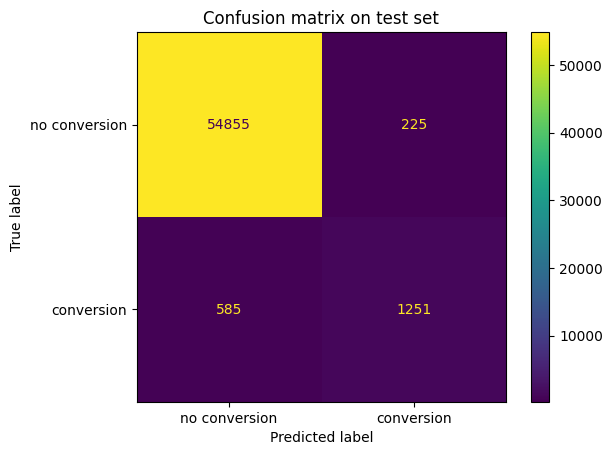

In [74]:
# We also check performance through the Confusion matrix test set
_,ax = plt.subplots() # The returned object is a tuple containing a figure and an Axes object. we don't use the figure
ax.set(title="Confusion matrix on test set")
# we use a function for displaying confusion matrices, from scikit-learn
ConfusionMatrixDisplay.from_estimator(classifier,
                                      X_test,
                                      Y_test,
                                      ax=ax,
                                      display_labels=["no conversion","conversion"])
plt.show()

Our baseline model reaches a f1-score of almost 76% which is not very high. Our model has some difficulties to detect conversion, doing a lot of mistakes.

Indeed, according to the matrix confusion on test set above, 225 conversion were predicted but in fact there were not (on a total of 1 251 + 227 conversion prediction )

#### D- Regularisation and Hyperparameters optimisation

In [75]:
# we set the number of iteration to 1000 (max_iter) and we'll adjust later if needed
classifier = LogisticRegression(max_iter=1000)

# we used three hyperparameters
# c = inverse of regularization strength
# solver = algorithm to use in the optimization problem
# penalty = specify the norm of the penalty
params = {
    "C" : [0.01, 0.1, 0.25, 0.4, 0.6, 0.8],
    "solver" : ["liblinear","lbfgs","newton-cg","sag","saga"], # we removed "newton-cholesky" as it generates value error with l1
    "penalty" : ["l2","l1","elasticnet"]
}

# we retain a number of 5 cross validation
grid = GridSearchCV(classifier, # model to use
                    param_grid = params, # hyperparameters to use
                    scoring = "f1", # indicates the metric used to evaluate the performance of the model with different hyperparameters
                    cv=5) # specifies the number of folds for cross-validation. In this case, it's set to 5, meaning the dataset will be split into 5 parts
grid.fit(X_train, Y_train)

C:\Users\SD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning:


240 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\SD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\SD\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\P

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.01, 0.1, 0.25, 0.4, 0.6, 0.8],
                         'penalty': ['l2', 'l1', 'elasticnet'],
                         'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag',
                                    'saga']},
             scoring='f1')

In [76]:
# Predictions
Y_train_pred = grid.predict(X_train)
Y_test_pred = grid.predict(X_test)

In [77]:
# performance assessment
print("Best parameter : ", grid.best_params_)
print("Best F1 score :", f1_score(Y_train, Y_train_pred).round(4))
print("F1 score on test set :", f1_score(Y_test, Y_test_pred).round(4))

Best parameter :  {'C': 0.4, 'penalty': 'l1', 'solver': 'liblinear'}
Best F1 score : 0.7655
F1 score on test set : 0.7554


Results aren't improved with this optimization.

In [78]:
# allow to get features names after preprocessing
encoded_cols = list(preprocessor.get_feature_names_out(X.columns))

In [79]:
# Analysis of feature importance
# create a dataframe with features name and their coefficients
features_analysis = pd.DataFrame(index=encoded_cols, # name of features after preprocessing as index
                                 data = grid.best_estimator_.coef_.transpose(), # coefficient for each feature as values
                                 columns=["Coefs"]) # column name

# as the number of features isn't significant, we made the choice to show them all
# we could also retain the absolut value of the coefficient, and sort them by decreasing value (we did that in Part 4)
features_analysis

,Coefs
num__age,-0.592299
num__total_pages_visited,2.545221
cat__country_Germany,3.572521
cat__country_UK,3.418324
cat__country_US,3.045711
cat__new_user_1,-1.687277
cat__source_Direct,-0.190220
cat__source_Seo,-0.039767


As seen before, age and source aren't discriminant variables.

In [80]:
# add result to the summary table
result = pd.DataFrame({"Train_set" : f1_score(Y_train, Y_train_pred).round(3),
                       "Test_set" : f1_score(Y_test, Y_test_pred).round(3)},
                      index=["Optimised_Logistic_regression"])
model_results = pd.concat([model_results, result])
model_results

,Train_set,Test_set
Multivariate Logistic_regression,0.765,0.755
Optimised_Logistic_regression,0.766,0.755


#### E- Univariate model

Our analysis of the variables showed that correlations between explanatory variables and the target variable were very light.
A part from the "total_pages_visited" used in the baseline model with one feature.
We propose so to try a logisistic regression with only one variable, the main one ("total_pages_visited").

In [81]:
# Data selection
X = data.loc[:,["total_pages_visited"]]
Y = data.loc[:, "converted"]
X.head()

# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train_univ, X_test_univ, Y_train_univ, Y_test_univ = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)
print("...Done.")
print()

# preprocessing
num_features = ["total_pages_visited"]
num_transformer = StandardScaler()

print("début du preprocessing sur le jeu d'entrainement :")
X_train_univ = num_transformer.fit_transform(X_train_univ)
print("...Done")
print("Encoding categorical features and standardizing numerical features...")
X_test_univ = num_transformer.transform(X_test_univ)
print("...Done")

# Train model
print("Train model...")
classifier_univariate = LogisticRegression(max_iter=1000)
classifier_univariate.fit(X_train_univ, Y_train_univ)
print("...Done.")

# Predictions
print("Predictions on training set...")
Y_train_pred = classifier_univariate.predict(X_train_univ)
print("...Done.")
print("Predictions on training set...")
Y_test_pred = classifier_univariate.predict(X_test_univ)
print("...Done.")

# Performance assessment
print("f1-score on train set : ", f1_score(Y_train_univ, Y_train_pred).round(4))
print("f1-score on test set : ", f1_score(Y_test_univ, Y_test_pred).round(4))

Dividing into train and test sets...
...Done.

début du preprocessing sur le jeu d'entrainement :
...Done
Encoding categorical features and standardizing numerical features...
...Done
Train model...


...Done.
Predictions on training set...
...Done.
Predictions on training set...
...Done.
f1-score on train set :  0.6991
f1-score on test set :  0.6793


The performance of the model is significantly less good with only one feature.

In [82]:
# add result to the summary table
result = pd.DataFrame({"Train_set" : f1_score(Y_train_univ, Y_train_pred).round(3),
                       "Test_set" : f1_score(Y_test_univ, Y_test_pred).round(3)},
                      index=["Univariate_Logistic_regression"])
model_results = pd.concat([model_results, result])
model_results

,Train_set,Test_set
Multivariate Logistic_regression,0.765,0.755
Optimised_Logistic_regression,0.766,0.755
Univariate_Logistic_regression,0.699,0.679


#### F- Multivariate model with clean dataset without outliers

We propose to test our model with a clean dataset without outliers from columns "age" and "total_pages_visited".

In [83]:
# data selection
target_variable = "converted"
X = data_clean.iloc[:,:-1]
Y = data_clean.loc[:, target_variable]

# Divide dataset Train set & Test set 
X_train_clean, X_test_clean, Y_train_clean, Y_test_clean = train_test_split(X, Y, test_size=0.2, random_state=0, stratify=Y)

# preprocessing
# set preprocessing for categorical features
cat_features = ["country", "new_user","source"]
cat_transformer = OneHotEncoder(drop="first")
# set preprocessing for numerical features
num_features = ["age","total_pages_visited"]
num_transformer = StandardScaler()
# combine the two kinds of preprocessing
preprocessor = ColumnTransformer(transformers=[
    ("num", num_transformer,num_features),
    ("cat", cat_transformer, cat_features)
])

# apply preprocessing to features
X_train_clean = preprocessor.fit_transform(X_train_clean)
X_test_clean = preprocessor.fit_transform(X_test_clean)

# Train model
classifier_clean = LogisticRegression(max_iter=1000)
classifier_clean.fit(X_train_clean, Y_train_clean)

# Predictions
Y_train_pred = classifier_clean.predict(X_train_clean)
Y_test_pred = classifier_clean.predict(X_test_clean)

# Performance assessment
print("f1-score on train set : ", f1_score(Y_train_clean, Y_train_pred).round(4))
print("f1-score on test set : ", f1_score(Y_test_clean, Y_test_pred).round(4))

f1-score on train set :  0.5063
f1-score on test set :  0.4972


Performance are widely less significant.
Indeed, by removing outliers we also removed informations used to understand correlation between featutres and the target.

In [84]:
# add result to the summary table
result = pd.DataFrame({"Train_set" : f1_score(Y_train_clean, Y_train_pred).round(3),
                       "Test_set" : f1_score(Y_test_clean, Y_test_pred).round(3)},
                      index=["Multivariate_Logistic_regression_clean"])
model_results = pd.concat([model_results, result])
model_results

,Train_set,Test_set
Multivariate Logistic_regression,0.765,0.755
Optimised_Logistic_regression,0.766,0.755
Univariate_Logistic_regression,0.699,0.679
Multivariate_Logistic_regression_clean,0.506,0.497


## PART 3 - RANDOM FOREST WITH OPTIMISATION

A Random Forest is an ensemble learning method used for both classification and regression tasks. It operates by constructing a multitude of decision trees during training and outputs the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

Ensemble learning involves training multiple models and combining them to obtain a stronger predictive performance than that of a single model.

The "random" in Random Forest comes from introducing randomness in two key ways:
- Bootstrap Sampling (Bagging): During the training of each tree, a random sample of the training data is selected with replacement. This process is known as bootstrap sampling, and it introduces diversity among the trees.
- Feature Randomness: When splitting a node in a decision tree, only a random subset of features is considered for the split. This helps in reducing the correlation between individual trees.

#### A- Train model

In [85]:
# instantiate our classifier
print("Starting Grid Search ......")
random_forest = RandomForestClassifier()

# we chose various values for a selection of hyperparameters
# max_depth = maximum depth of the tree
# min_sample_leaf = minimum number of samples required to be at a leaf node
# min_samples_split = minimum number of samples required to split an internal node
# n_esimators = number of trees in the forest
params = {
    "max_depth" : [5,8,10],
    "min_samples_leaf" : [1,2,5,6],
    "min_samples_split" : [2,4,6],
    "n_estimators" : [10,20,40,60,80]
}

# train the model with gridsearch cv and 3 validations
# we retain F1_score to measure performance
grid_random = GridSearchCV(random_forest,
                           param_grid=params,
                           scoring="f1",
                           cv=3, # we reduced the number of validations in order to avoid a too long time of training
                           n_jobs=-1) # number of jobs to run in parallel. Setting it to -1 means that the computation will be distributed across all available CPU

grid_random.fit(X_train, Y_train)
print("......Done.")

Starting Grid Search ......


......Done.


In [86]:
print("Best parameters : ", grid_random.best_params_)

Best parameters :  {'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 2, 'n_estimators': 40}


In [87]:
# Predictions on train and test set
print("Predictions on training set...")
Y_train_pred = grid_random.predict(X_train)
print("...Done.")
print("Predictions on test set...")
Y_test_pred = grid_random.predict(X_test)
print("...Done.")

Predictions on training set...


...Done.
Predictions on test set...
...Done.


#### B- Performance assessment

In [88]:
print("f1-score on train set : ", f1_score(Y_train, Y_train_pred).round(4))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred).round(4))

f1-score on train set :  0.7752
f1-score on test set :  0.747


In [89]:
# add results to the summary table
result = pd.DataFrame({"Train_set" : f1_score(Y_train, Y_train_pred).round(3),
                       "Test_set" : f1_score(Y_test, Y_test_pred).round(3)},
                      index = ["Optimised_Random_forest"])

model_results = pd.concat([model_results,result])
model_results

,Train_set,Test_set
Multivariate Logistic_regression,0.765,0.755
Optimised_Logistic_regression,0.766,0.755
Univariate_Logistic_regression,0.699,0.679
Multivariate_Logistic_regression_clean,0.506,0.497
Optimised_Random_forest,0.775,0.747


There is no really improvment in the performance at this point.

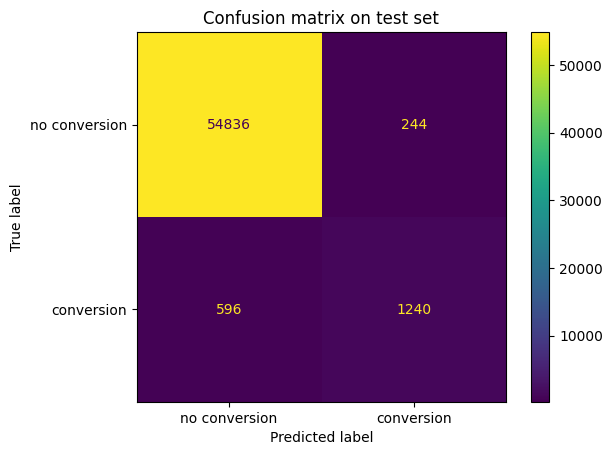

In [90]:
# We also check performance through the Confusion matrix
_,ax = plt.subplots()
ax.set(title="Confusion matrix on test set")
ConfusionMatrixDisplay.from_estimator(grid_random,
                                      X_test,
                                      Y_test,
                                      ax=ax,
                                      display_labels=["no conversion","conversion"])
plt.show()

In [91]:
print(classification_report(Y_test,
                            Y_test_pred,
                            target_names=["no conversion","conversion"]))

               precision    recall  f1-score   support

no conversion       0.99      1.00      0.99     55080
   conversion       0.84      0.68      0.75      1836

     accuracy                           0.99     56916
    macro avg       0.91      0.84      0.87     56916
 weighted avg       0.98      0.99      0.98     56916



## PART 4 - TRAIN BEST CLASSIFIER ON ALL DATA AND USE IT TO MAKE PREDICTIONS ON X_WITHOUT_LABELS
Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [ ]:
# Concatenate our train and test set to train your best classifier on all data with labels
X_global = np.append(X_train,X_test,axis=0)
Y_global = np.append(Y_train,Y_test)

# use the first model that gives the best results
classifier.fit(X_global,Y_global)

LogisticRegression(max_iter=1000)

In [ ]:
# Read data without labels
X_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', X_without_labels.shape)

X_without_labels.head()

Prediction set (without labels) : (31620, 5)


,country,age,new_user,source,total_pages_visited
0,UK,28,0,Seo,16
1,UK,22,1,Direct,5
2,China,32,1,Seo,1
3,US,32,1,Ads,6
4,China,25,0,Seo,3


In [ ]:
print("Encoding categorical features and standardizing numerical features...")

# preprocess features
X_without_labels_prep = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels_prep[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.30718036  3.95417859  0.          1.          0.          0.
   0.          1.        ]
 [-1.04537291  0.12356222  0.          1.          0.          1.
   1.          0.        ]
 [ 0.18494801 -1.26938919  0.          0.          0.          1.
   0.          1.        ]
 [ 0.18494801  0.47180007  0.          0.          1.          1.
   0.          0.        ]
 [-0.67627663 -0.57291348  0.          0.          0.          0.
   0.          1.        ]]


In [ ]:
# see size of the dataset
X_without_labels_prep.shape

(31620, 8)

Instructions :
- Make predictions and dump to file
- WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
- WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
- where [name] is the name of your team/model separated by a '-'
- For example : [name] = AURELIE-model1

In [ ]:
# make predictions and put it on a dictionary
data = {
    'converted': classifier.predict(X_without_labels_prep)
}

# transform distionary into dataframe
Y_predictions = pd.DataFrame(columns=['converted'],data=data)

# save dataframe to a csv file
Y_predictions.to_csv('conversion_data_test_predictions_DuplandSylvain-model1.csv', index=False)

In [ ]:
Y_predictions.value_counts() / Y_predictions.shape[0] * 100

converted
0            97.390892
1             2.609108
Name: count, dtype: float64

The conversion rate is estimated at around 2,6% on this new dataset.

In [ ]:
# Analyze of coefficients for each features
encoded_cols = list(preprocessor.get_feature_names_out(X_without_labels.columns)) # allow to get features names after preprocessing
coefs = pd.DataFrame(index=encoded_cols, # name of features after preprocessing as index
                     data = classifier.coef_.transpose(), # coefficient for each feature as values
                     columns=["Coefficients"]) # column name

# we sort absolute value of coefficients by decreasing order
coefs = abs(coefs).sort_values(by="Coefficients", ascending=False)

In [ ]:
# the results
coefs

,Coefficients
cat__country_Germany,3.523879
cat__country_UK,3.371646
cat__country_US,3.007002
num__total_pages_visited,2.175859
cat__new_user_1,1.717968
num__age,0.600611
cat__source_Direct,0.211001
cat__source_Seo,0.005732


As expected, source and age aren't explicative variables.

## PART 5 - CONCLUSIONS

At least, the logistic regression model with all the features gives the best results at a first look.

In order to improve the model performance, we could try to get new features linked to the customer profile.

For example the kind of pages visited (subjects), or the time stayed on the website.

We could also try with a xgboost model but i'm not sure that results will be really better.